# Gated Recurrent Unit
Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.

GRU는 Vanilla RNN보다 더 발전한 순환 신경망 아키텍처  
게이트 메커니즘을 사용하여 장기 의존성을 더 잘 처리하고 더 빠른 학습 속도를 제공.

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv('kospi.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000
...,...,...,...,...,...,...,...
426,2020-10-26,2366.500000,2374.500000,2342.580078,2343.909912,2343.909912,822300
427,2020-10-27,2328.659912,2349.330078,2321.229980,2330.840088,2330.840088,666900
428,2020-10-28,2324.179932,2345.459961,2316.469971,2345.260010,2345.260010,705200
429,2020-10-29,2312.340088,2330.169922,2299.909912,2326.669922,2326.669922,509100


In [47]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
# cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone

device(type='cpu')

In [49]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [50]:
def seq_data(x, y, sequence_length):

    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [51]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [52]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [53]:
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
input_size, x_seq.size()

(4, torch.Size([426, 5, 4]))

In [54]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        # print(h0.shape) torch.Size([2, 20, 8])
        out, _ = self.gru(x, h0)
        # print(out.shape) torch.Size([20, 5, 8])
        out = out.reshape(out.shape[0], -1) # <- state 추가
        # print(out.shape) torch.Size([20, 40])
        out = self.fc(out)
        return out

In [55]:
model = GRU(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers, device=device)

model = model.to(device)

In [28]:
input_size, hidden_size, sequence_length, num_layers

(4, 8, 5, 2)

In [30]:
model.parameters

<bound method Module.parameters of GRU(
  (gru): GRU(4, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)>

**GRU**(   
batch_first=True
> (batch, seq, feature)   

batch_first=False
> (seq, batch, feature)  

)

In [56]:
criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=lr)

In [34]:
from tqdm import tqdm

In [57]:
loss_graph = []
n = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    for i, data in enumerate(train_loader, start=0):

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

  2%|▏         | 6/301 [00:00<00:11, 25.28it/s]

[epoch: 0] loss: 0.3276


 35%|███▍      | 105/301 [00:04<00:07, 25.16it/s]

[epoch: 100] loss: 0.0019


 68%|██████▊   | 205/301 [00:09<00:05, 18.52it/s]

[epoch: 200] loss: 0.0009


100%|██████████| 301/301 [00:13<00:00, 23.07it/s]

[epoch: 300] loss: 0.0008


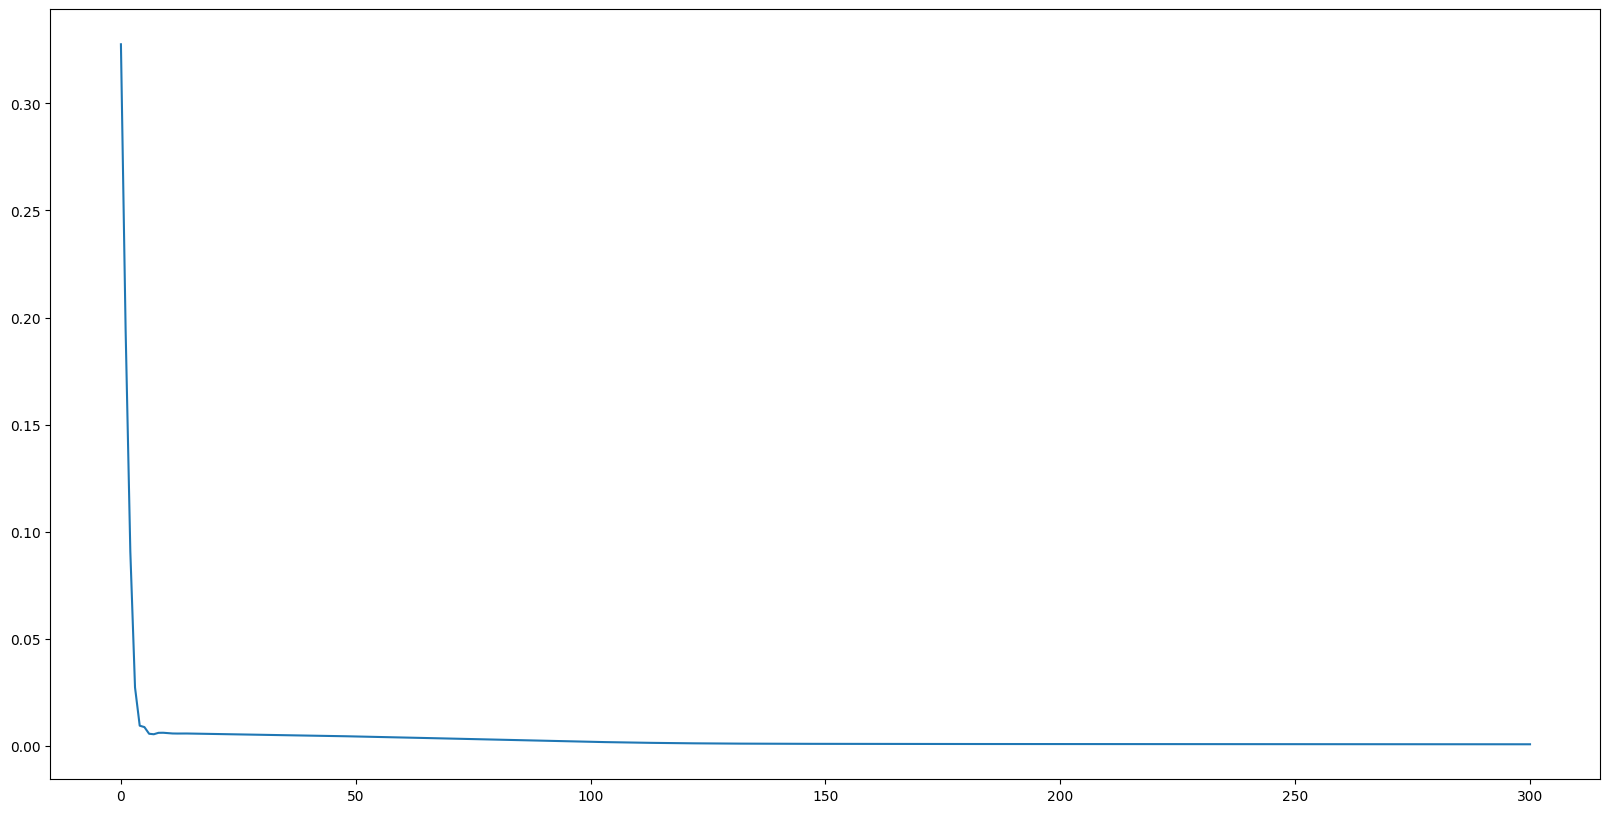

In [58]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [63]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

In [64]:
with torch.no_grad():
    pred = []

    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

In [71]:
out.shape, len(pred)

(torch.Size([26, 1]), 426)

In [66]:
sequence_length

5

In [73]:
np.ones(100) * len(train)

array([200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200.])

In [81]:
train.tensors[0].shape, train.tensors[1].shape

(torch.Size([200, 5, 4]), torch.Size([200, 1]))

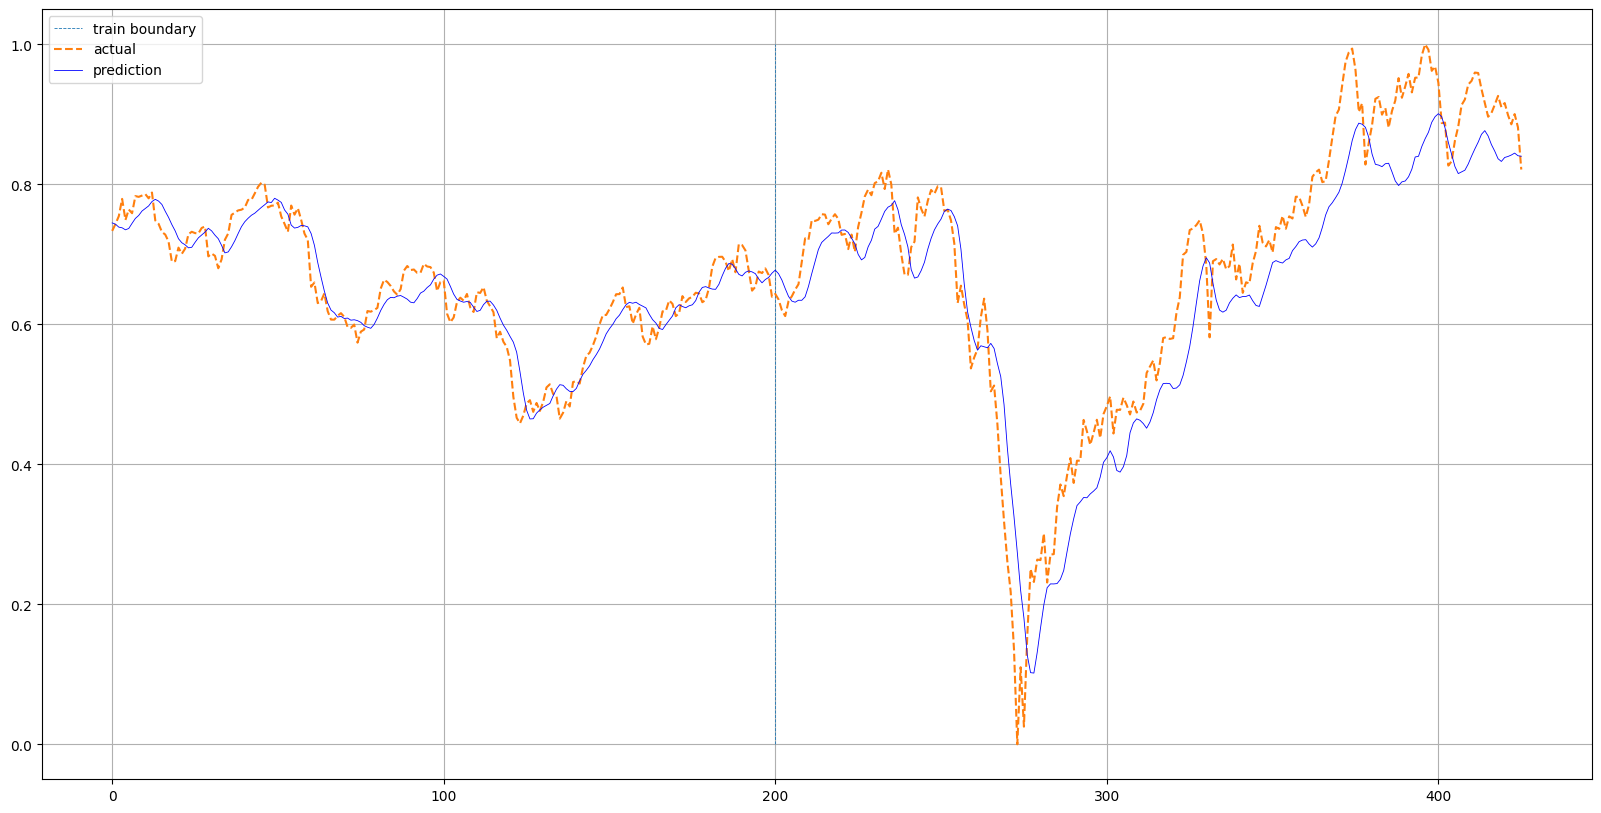

In [72]:
plt.figure(figsize=(20,10))

plt.plot(np.ones(100) * len(train), np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)

plt.legend(['train boundary','actual','prediction'])
plt.grid()
plt.show()